# Evaluation of Basic English Translator

To evaluate the [BasicEnglishTranslator](https://github.com/NeverForged/GhostWriter/blob/master/source/BasicEnglishTranslator.py),  I have scraped a number of entries from both [Simple English Wikipedia](https://simple.wikipedia.org/wiki/Main_Page) and regular (english) [Wikipeda](https://en.wikipedia.org/wiki/Main_Page).  For the latter, same articles, but more complex text (and a better test of the overall functionality, since it will encounter words it wasn't trained on initially).

First, to look through the articles and make sure they are valid:

In [1]:
# Loding in my articles, saved in the main running of BasicEnglishTranslator.py
import cPickle as pickle
articles = pickle.load(open('../data/articles.pickle', 'rb'))
keys = articles.keys()

In [2]:
si_entries = []
en_entries = []

bad = 'we could not find the above page on our servers. did you mean'
worse = 'wikipedia does not yet have an article with this name'

not_blank = 0
all_art = 0
for key in articles.keys():
    not_blank += 1
    if (bad in articles[key][2] or worse in articles[key][2] or 'mean:' in articles[key][2] or 
        'wikipedia help' in articles[key][2] or 'refer to' in articles[key][2] or 'may be about' in articles[key][2]):
        pass
    else:
        if key[:2] == 'en':
            en_entries.append((articles[key][0], articles[key][2]))
        elif key[:2] == 'si':
            si_entries.append((articles[key][0], articles[key][2]))

print 'We have {} articles (of {} non-blank).'.format(len(si_entries) + len(en_entries), not_blank)

We have 1568 articles (of 1963 non-blank).


We can judge the general complexity of these articles using [Flesch-Kincaid](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch.E2.80.93Kincaid_grade_level) reading-ease scores... 

In [3]:
def count_syllables(word):
    count = 0
    vowels = 'aeiouy'
    word = word.lower().strip(".:;?!")
    try:
        if word[0] in vowels:
            count +=1
        for index in range(1,len(word)):
            if word[index] in vowels and word[index-1] not in vowels:
                count +=1
        if word.endswith('e'):
            count -= 1
        if word.endswith('le'):
            count+=1
        if count == 0:
            count +=1
        return count
    except:
        return 0

In [4]:
from nltk.corpus import cmudict
from nltk import pos_tag, word_tokenize
import string
import re

def calc_fk(text):
    '''
    Flesch-Kincaid gives the approximate US School reading level of text:
             0.39 (words/sentences) + 11.8(syllables/words) - 115.59
    '''
    punctuation = ".?!"
    prt = set(string.printable)
    if type(text) ==  list:
        text = ' '.join(text)
    text = filter(lambda x: x in prt, text)
    text = text.encode('utf-8')
    text = re.sub("\xe2\x80\x93", "-", text)
    sentences = 0
    syllables = 0
    n_words = 0
    words = pos_tag(word_tokenize(text))
    text = text
    for word in words:
        if word[1] in punctuation:
            sentences += 1.0
        elif len(word[1]) >= 2:
            syllables += float(count_syllables(word[0]))
            n_words += 1.0
    else:
        if sentences == 0 or sentences == 0.0:
            sentences = 1.0
        try:
            return 0.39 * (n_words/sentences) + 11.8 * (syllables/n_words) - 15.59
        except:
            print sentences, n_words

We will now calculate the Flesch-Kincaid grade-level of our articles, both the original and the translated.

In [5]:
import numpy as np

Xb = []
yb = []
Xr = []
yr = []
for text in en_entries:
    Xr.append([calc_fk(text[0]), calc_fk([text[1]])])
    yr.append('r')

for text in si_entries:
    Xb.append([calc_fk(text[0]), calc_fk([text[1]])])
    yb.append('b')
    
Xb = np.array(Xb)
Xr = np.array(Xr)

First, we can look at New Flesch-Kincaid Reading Level as a function of the Original Flesch-Kincaid Reading Level:

In [6]:
# find most-simplified and average simplification
best = ('a','122')
total = []
for i, x in enumerate(Xb):
    new = x[0] - x[1]
    total.append(new)
    if new < best[1]:
        best = (si_entries[i], new)

blue = np.mean(total)
total = []

for i, x in enumerate(Xr):
    new = x[0] - x[1]
    total.append(new)
    if new < best[1]:
        best = (en_entries[i], new)
        
print best
red = np.mean(total)

(('decay is a baal in? lvdalen town in dalarna state in portugal. in 2010, 695 people lived there. [ 1 ]', 'rot is a locality in ?lvdalen municipality in dalarna county in sweden. in 2010, 695 people lived there. [1]'), -3.93333333333333)


C:\Users\darin\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  import sys


C:\Users\darin\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


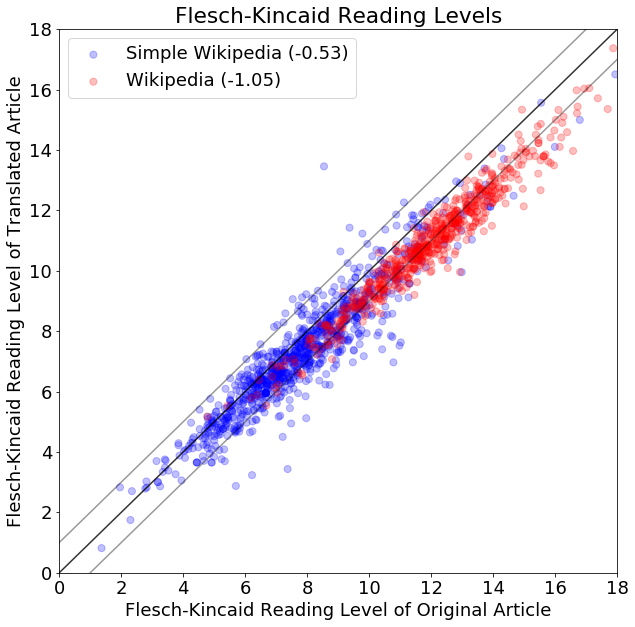

In [7]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=(10, 10))
plt.title("Flesch-Kincaid Reading Levels")
plt.xlabel('Flesch-Kincaid Reading Level of Original Article')
plt.ylabel('Flesch-Kincaid Reading Level of Translated Article')
xx = np.linspace(0.0, 18, 19)
yy = xx
plt.xlim(0, 18)
plt.ylim(0, 18)
plt.plot(xx, yy, c='k', alpha=0.8)
plt.scatter(Xb[:, 1], Xb[:, 0], label='Simple Wikipedia ({:.2f})'.format(blue), c=yb, s=50, alpha=0.25)
plt.scatter(Xr[:, 1], Xr[:, 0], label='Wikipedia ({:.2f})'.format(red), c=yr, s=50, alpha=0.25)
# plt.scatter(Xr[:, 1], Xr[:, 0], c=yr, s=100, alpha=0.25)
#plt.plot(xx, yy+1, c='k', alpha=0.4, label='+/- 1 Grade Level')
plt.plot(xx, yy-1, c='k', alpha=0.4)
plt.plot(xx, yy+1, c='k', alpha=0.4)
# plt.text(1, 2.35, '+1')
# plt.text(1, .25, '-1')
#plt.text(0.25, 17, r'$\Delta$GL$_A$$_V$$_E$ = ${:.2f}$'.format(red))
plt.legend()
plt.show()

Now we can look at which documents have become easier to read and which have become harder to read; we'll do this by graphing the original reading level on the x-axis, and new - original on the y-axis.  Documents in the lower-half of the graph have become easier to read.

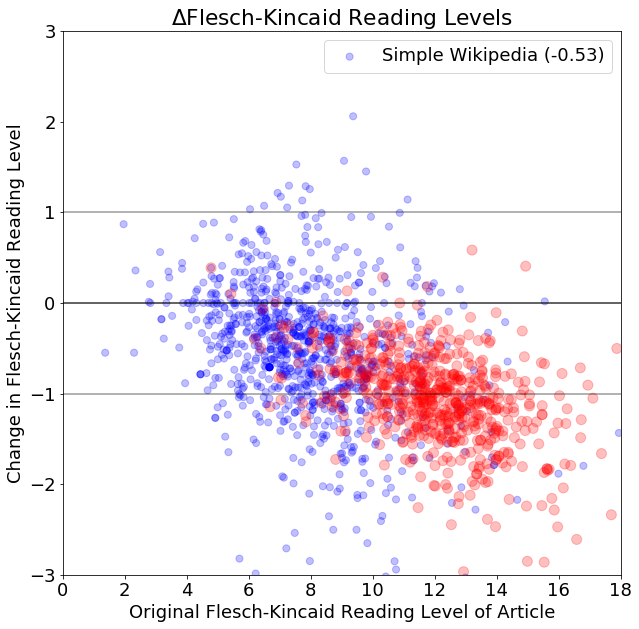

In [8]:
plt.figure(figsize=(10, 10))
plt.title(r"$\Delta$Flesch-Kincaid Reading Levels")
plt.xlabel('Original Flesch-Kincaid Reading Level of Article')
plt.ylabel('Change in Flesch-Kincaid Reading Level')
xx = np.linspace(0.0, 18, 19)
yy = xx*0.0
plt.xlim(0, 18)
plt.ylim(-3, 3)

plt.plot(xx, yy, c='k', alpha=0.8)
plt.scatter(Xb[:, 1], Xb[:, 0] - Xb[:, 1], label='Simple Wikipedia ({:.2f})'.format(blue), c=yb, s=50, alpha=0.25)
plt.scatter(Xr[:, 1], Xr[:, 0] - Xr[:, 1], c=yr, s=100, alpha=0.25)
#plt.scatter(Xr[:, 1], Xr[:, 0] - Xr[:, 1], c=yr, s=100, alpha=0.25)
#plt.plot(xx, yy+1, c='k', alpha=0.4, label='+/- 1 Grade Level')
plt.plot(xx, yy-1, c='k', alpha=0.4)
plt.plot(xx, yy+1, c='k', alpha=0.4)
# plt.text(xx[3], yy[-3], r'$\Delta$GL = ${:.2f}$'.format(red))
# plt.text(1, .25, '-1')
plt.legend()
plt.show()